In [1]:
import os
import glob
from dotenv import load_dotenv
from groq import Groq
import pptx

In [2]:
load_dotenv()
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [3]:
prs = pptx.Presentation("pptbase/Day-1.pptx")
text_runs = []
for_slidestext = {}
slideno = 0
for slide in prs.slides:

    textruns_slide=[]
    for shape in slide.shapes:
        if not shape.has_text_frame:
            continue
        for paragraph in shape.text_frame.paragraphs:
            for run in paragraph.runs:
                textruns_slide.append(run.text)
            for_slidestext = for_slidestext | {f"{slideno}": textruns_slide}
    slideno+=1

In [14]:
for_slidestext

{'0': ['Global ', 'TestOps', ' Workshop', 'Brazil', 'Feb 3-7, 2025'],
 '1': ['Agenda',
  '01',
  '02',
  '03',
  '04',
  '05',
  '06',
  'Kickoff & Opening Remarks by Leaders',
  'TestOps',
  ' Overview, Journey & 2025 Vision',
  'Measurement Fundamentals : What, Why & How of Decision Making',
  'Measurement Best Practices: Process, Governance & Ideal Ways-of-Working',
  'Hypothesis Generation & Key Learnings from Experiments Across Zones',
  'Data Landscape Overview - Importance of Data Quality & Reliability'],
 '2': ['Agenda',
  '01',
  '02',
  '03',
  '04',
  '05',
  '06',
  'Kickoff & Opening Remarks by Leaders',
  'TestOps',
  ' Overview, Journey & 2025 Vision',
  'Measurement Fundamentals : What, Why & How of Decision Making',
  'Measurement Best Practices: Process, Governance & Ideal Ways-of-Working',
  'Hypothesis Generation & Key Learnings from Experiments Across Zones',
  'Data Landscape Overview - Importance of Data Quality & Reliability'],
 '3': ['Agenda',
  '01',
  '02',
 

In [32]:
import os
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE 

def extract_images_from_pptx(pptx_path, output_dir):
    # Load the presentation
    presentation = Presentation(pptx_path)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate through slides and shapes to find images
    image_count = 0
    for slide_idx, slide in enumerate(presentation.slides):
        slide_dir = os.path.join(output_dir, f"slide_{slide_idx}")
        os.makedirs(slide_dir, exist_ok=True)  # Create per-slide directory
        
        for shape in slide.shapes:
            if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                image = shape.image
                image_bytes = image.blob
                image_filename = f"image_{image_count}.{image.ext}"
                image_path = os.path.join(slide_dir, image_filename)

                # Save the image
                with open(image_path, 'wb') as f:
                    f.write(image_bytes)

                image_count += 1
                print(f"Saved {image_filename} in {slide_dir}")

# Example usage
pptx_path = 'pptbase/Day-1.pptx'
output_dir = 'extracted_images'
extract_images_from_pptx(pptx_path, output_dir)


Saved image_0.png in extracted_images\slide_4
Saved image_1.png in extracted_images\slide_4
Saved image_2.png in extracted_images\slide_4
Saved image_3.png in extracted_images\slide_4
Saved image_4.png in extracted_images\slide_4
Saved image_5.png in extracted_images\slide_4
Saved image_6.png in extracted_images\slide_5
Saved image_7.png in extracted_images\slide_7
Saved image_8.png in extracted_images\slide_7
Saved image_9.png in extracted_images\slide_7
Saved image_10.png in extracted_images\slide_7
Saved image_11.png in extracted_images\slide_7
Saved image_12.png in extracted_images\slide_7
Saved image_13.png in extracted_images\slide_7
Saved image_14.png in extracted_images\slide_8
Saved image_15.png in extracted_images\slide_8
Saved image_16.png in extracted_images\slide_8
Saved image_17.png in extracted_images\slide_9
Saved image_18.png in extracted_images\slide_9
Saved image_19.png in extracted_images\slide_9
Saved image_20.png in extracted_images\slide_9
Saved image_21.png in e

In [2]:
import os
import json
import io
import cv2
import numpy as np
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from PIL import Image, ImageDraw, ImageFont
from fpdf import FPDF

class PPTProcessor:
    def __init__(self, ppt_path, output_folder="output"):
        self.ppt_path = ppt_path
        self.output_folder = output_folder
        self.presentation = Presentation(ppt_path)
        self.slides_data = []

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
    
    def extract_text(self, slide):
        """Extracts all text from a slide."""
        text_content = []
        for shape in slide.shapes:
            if hasattr(shape, "text") and shape.text.strip():
                text_content.append(shape.text.strip())
        return "\n".join(text_content)

    def extract_images(self, slide, slide_num):
        """Extracts images from a slide and saves them."""
        image_paths = []
        for i, shape in enumerate(slide.shapes):
            if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                image_stream = shape.image.blob
                img = Image.open(io.BytesIO(image_stream))
                img_path = os.path.join(self.output_folder, f"slide_{slide_num}_img_{i}.png")
                img.save(img_path)
                image_paths.append(img_path)
        return image_paths

    def render_slide_as_image(self, slide_text, slide_num):
        """Creates a rough reconstruction of the slide as an image."""
        img = Image.new("RGB", (1280, 720), (255, 255, 255))
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()

        text_lines = slide_text.split("\n")
        y_position = 50
        for line in text_lines:
            draw.text((50, y_position), line, fill=(0, 0, 0), font=font)
            y_position += 30

        img_path = os.path.join(self.output_folder, f"slide_{slide_num}.png")
        img.save(img_path)
        return img_path

    def process_ppt(self):
        """Processes each slide and extracts text, images, and renders an image."""
        document_title = os.path.basename(self.ppt_path)
        document_location = os.path.abspath(self.ppt_path)

        for slide_num, slide in enumerate(self.presentation.slides, start=1):
            slide_text = self.extract_text(slide)
            images = self.extract_images(slide, slide_num)
            rendered_image_path = self.render_slide_as_image(slide_text, slide_num)

            slide_data = {
                "document_title": document_title,
                "document_location": document_location,
                "page_num": slide_num,
                "image_of_slide": rendered_image_path,
                "pptx_content": slide_text,
                "extracted_images": images
            }

            self.slides_data.append(slide_data)
        
        return self.slides_data

    def save_to_json(self, output_filename="slides_data.json"):
        """Saves extracted slide data to a JSON file."""
        json_path = os.path.join(self.output_folder, output_filename)
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(self.slides_data, f, indent=4)
        print(f"Saved JSON file at {json_path}")

# Usage
if __name__ == "__main__":
    ppt_file = "pptbase/Day-1.pptx" 
    processor = PPTProcessor(ppt_file)
    slides_data = processor.process_ppt()
    processor.save_to_json()


Saved JSON file at output\slides_data.json


In [ ]:
import ollama

response = ollama.chat(
    model='deepseek-r1:1.5b',
    messages=[
        {'role': 'user', 'content': ' what is the probability of pulling 4 ace of spades from a deck of cards?'}
    ]
)

# Print the response
print(response['message']['content'])

<think>
To determine the probability of pulling the four Aces of Spades one by one without any replacements, I start by noting that there are 52 distinct cards in a standard deck.

Each Ace has an equal chance to be drawn first, which is 1/52. After drawing the first Ace of Spades, there are 51 remaining cards, and only 1 Ace of Spades left. The probability of drawing it next is 1/51.

This pattern continues for each subsequent draw: after each Ace is removed, the total number of cards decreases by one, reducing the denominator by one as well. Therefore, the probability of pulling all four Aces of Spades in succession without replacement is the product of these individual probabilities.
</think>

To determine the probability of pulling the **four Aces of Spades** one by one without any replacements from a standard deck of cards, follow these steps:

### **Step 1: Understand the Deck Composition**
- **Total Cards in a Deck:** 52
- **Aces of Spades:** There is only **1 Ace of Spades** in

In [10]:
!ollama pull phi4

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling fd7b6731c33c... 100% ▕████████████████▏ 9.1 GB                         
pulling 32695b892af8... 100% ▕████████████████▏  275 B                         
pulling fa8235e5b48f... 100% ▕████████████████▏ 1.1 KB                         
pulling 45a1c652dddc... 100% ▕████████████████▏   82 B                         pulling manifest 
pulling fd7b6731c33c... 100% ▕████████████████▏ 9.1 GB                         
pulling 32695b892af8... 100% ▕████████████████▏  275 B                         
pulling fa8235e5b48f... 100% ▕████████████████▏ 1.1 KB                         
pulling 45a1c652dddc... 100% ▕████████████████▏   82 B                         
pulling f5d6f49c6477... 100% ▕████████████████▏  486 B                         
verifying sha256 

In [4]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [ ]:
for_slidestext

In [7]:
paraslides = {}
import ollama
for key in for_slidestext:
    prompt = ""
    for item in for_slidestext[key]:
        prompt+=f"\n{item}"
    response = ollama.chat(
    model='deepseek-r1:1.5b',
    messages=[
        {'role':"system", 'content': "Summarise the following text in around 50 words"},
        {'role': 'user', 'content': f'{prompt}'}
    ]
)
    print(key)
    # Print the response
    paraslides= paraslides | {key: response['message']['content']}

ConnectionError: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download

In [6]:
for key in paraslides:
    paraslides[key] = paraslides[key].split("</think>")[1]

NameError: name 'paraslides' is not defined

In [17]:
paraslides

{'0': '\n\nTestOps Workshop in Brazil Feb 3-7, 2025',
 '1': '\n\nAgenda from 01 to 06 with TestOps overview, journey, 2025 vision; measurement fundamentals and best practices; hypothesis generation & learnings from experiments; data landscape: importance of quality & reliability.',
 '2': '\n\nAgenda  \n- TestOps Overview, Journey & 2025 Vision  \n- Measurement Fundamentals: What, Why & How of Decision Making  \n- Measurement Best Practices: Process, Governance & Ideal Ways-of-Working  \n- Hypothesis Generation & Key Learnings from Experiments Across Zones  \n- Data Landscape Overview - Importance of Data Quality & Reliability',
 '3': '\n\nHere’s a concise summary of your text:\n\n**Agenda by Leaders; TestOps Overview: Journey & Vision**\n\n**Measurements; Best Practices**\n\n**Hypotheses from Experiments in Zones**\n\n**Data Landscape Overview: Importance of Data Quality**',
 '4': '\n\nThe project evolved from 2022-2023 with use cases including Promo/Portfolio optimization, Investment/

In [19]:
os.makedirs("text_output", exist_ok=True)

In [4]:
import json

In [5]:
json_path = os.path.join("text_output", "paraslides.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(paraslides, f, indent=4)
print(f"Saved JSON file at {json_path}")

NameError: name 'paraslides' is not defined

In [8]:
import json

# Open and read the JSON file
with open('text_output/paraslides-deepseek.json', 'r') as file:
    data = json.load(file)

# Print the data
print(data)

{'0': '\n\nTestOps Workshop in Brazil Feb 3-7, 2025', '1': '\n\nAgenda from 01 to 06 with TestOps overview, journey, 2025 vision; measurement fundamentals and best practices; hypothesis generation & learnings from experiments; data landscape: importance of quality & reliability.', '2': '\n\nAgenda  \n- TestOps Overview, Journey & 2025 Vision  \n- Measurement Fundamentals: What, Why & How of Decision Making  \n- Measurement Best Practices: Process, Governance & Ideal Ways-of-Working  \n- Hypothesis Generation & Key Learnings from Experiments Across Zones  \n- Data Landscape Overview - Importance of Data Quality & Reliability', '3': '\n\nHere’s a concise summary of your text:\n\n**Agenda by Leaders; TestOps Overview: Journey & Vision**\n\n**Measurements; Best Practices**\n\n**Hypotheses from Experiments in Zones**\n\n**Data Landscape Overview: Importance of Data Quality**', '4': '\n\nThe project evolved from 2022-2023 with use cases including Promo/Portfolio optimization, Investment/POC 

In [ ]:
# for key in data:
#     data[key] = "Day-1 | ./pptbase/Day-1.pptx |"+data[key]

In [11]:
data

{'0': 'Day-1 | ./pptbase/Day-1.pptx |\n\nTestOps Workshop in Brazil Feb 3-7, 2025',
 '1': 'Day-1 | ./pptbase/Day-1.pptx |\n\nAgenda from 01 to 06 with TestOps overview, journey, 2025 vision; measurement fundamentals and best practices; hypothesis generation & learnings from experiments; data landscape: importance of quality & reliability.',
 '2': 'Day-1 | ./pptbase/Day-1.pptx |\n\nAgenda  \n- TestOps Overview, Journey & 2025 Vision  \n- Measurement Fundamentals: What, Why & How of Decision Making  \n- Measurement Best Practices: Process, Governance & Ideal Ways-of-Working  \n- Hypothesis Generation & Key Learnings from Experiments Across Zones  \n- Data Landscape Overview - Importance of Data Quality & Reliability',
 '3': 'Day-1 | ./pptbase/Day-1.pptx |\n\nHere’s a concise summary of your text:\n\n**Agenda by Leaders; TestOps Overview: Journey & Vision**\n\n**Measurements; Best Practices**\n\n**Hypotheses from Experiments in Zones**\n\n**Data Landscape Overview: Importance of Data Qual

In [2]:
import json

# Open and read the JSON file
with open('text_output/paraslides-deepseek.json', 'r') as file:
    data = json.load(file)

# Print the data
# for key in data:
#     data[key] = "Day-1 | ./pptbase/Day-1.pptx |"+data[key]

In [11]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Example data dictionary (add your full data dictionary here)


# Initialize the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient and accurate

# Generate embeddings
keys = list(data.keys())
texts = list(data.values())
embeddings = model.encode(texts, convert_to_tensor=True).detach().cpu().numpy()

# Create FAISS index
d = embeddings.shape[1]  # Vector dimension
index = faiss.IndexFlatL2(d)
index.add(embeddings)

# Example query
query = "How does TestOps improve decision-making?"
query_embedding = model.encode([query]).astype('float32')

# Search for closest match
_, closest_index = index.search(query_embedding, 3)

# Display results
print("Top Matches:")
for idx in closest_index[0]:
    print(f"{keys[idx]}: {data[keys[idx]]}")


Top Matches:
30: Day-1 | ./pptbase/Day-1.pptx |

Agenda 01-06 Kickoff & Opening Remarks by Leaders. TestOps Overview, Journey & 2025 Vision. Measurement Fundamentals: What, Why & How of Decision Making; Best Practices: Process, Governance, & Ideal Ways-of-Working. Hypothesis Generation & Key Learnings from Experiments. Data Landscape: Importance, Quality, & Reliability.
9: Day-1 | ./pptbase/Day-1.pptx |

TestOps drives innovation through experimentation, fostering a granular culture that enhances decision-making and enables businesses to adapt quickly while maximizing impact through data.
75: Day-1 | ./pptbase/Day-1.pptx |

TestOps aims for a Vision of 2025 with Simulation, Testing, & Learning methodologies, Embracing Ambition and Global Best Practices. Focus on Accuracy, Data-Driven Decision Making, and Robust Measurement Frameworks. Document Results, Train Teams, and Ensure Clear Reporting Standards. Drive Financial Discipline and Credible Outcomes with Informed Strategy Development.

In [12]:
import openai
def retrieve_context(query, top_k=3):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode([query]).astype('float32')
    _, closest_indices = index.search(query_embedding, top_k)
    return [texts[idx] for idx in closest_indices[0]]

# Function to generate response using OpenAI API
def generate_response(query):
    context = retrieve_context(query)
    prompt = f"Context: {' '.join(context)}\n\nQuestion: {query}\nAnswer:"
    
    response = openai.chat.completions.create(
        model="gpt-4", 
        messages=[{"role": "system", "content": "You are an expert assistant. give the relative path of the file given in context as well as the response"},
                  {"role": "user", "content": prompt}],
        max_tokens=200
    )
    
    return response.choices[0].message.content.strip()

# Example usage
query = "What is TestOps and how does it improve decision-making?"
response = generate_response(query)
print("Generated Response:\n", response)

Generated Response:
 TestOps is a strategy that drives innovation through experimentation. It fosters a detailed-oriented culture that enhances decision-making and enables businesses to adapt quickly while maximizing impact through data. It uses accurate, data-driven methods to make decisions and adheres to robust measurement frameworks. TestOps aims to document results, train teams, and ensure clear reporting standards. It also aims to drive financial discipline and produce credible outcomes with informed strategy development. By fostering continuous innovation, TestOps ultimately helps drive business impact through its robust methodologies.


In [1]:
%pip install comtypes

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# Kill existing PowerPoint processes
os.system("taskkill /f /im POWERPNT.EXE")


0

In [13]:
import comtypes.client
import time

def convert_pptx_to_pdf(input_pptx, output_pdf):
    try:
        # Start PowerPoint Application
        powerpoint = comtypes.client.CreateObject("PowerPoint.Application")
        powerpoint.Visible = 1  # 1 = Visible, 0 = Hidden

        # Open the presentation
        presentation = powerpoint.Presentations.Open(input_pptx, WithWindow=True)

        # Save as PDF (32 = PDF format)
        presentation.SaveAs(output_pdf, 32)

        # Close presentation and PowerPoint
        presentation.Close()
        powerpoint.Quit()

        print("Conversion successful!")

    except Exception as e:
        print(f"Error: {e}")

# Example Usage
convert_pptx_to_pdf(r"D:\pptx project\pptbase\Day-1.pptx", r"D:\pptx project\pptbase\Day-1.pdf")


Conversion successful!


In [11]:
%pip install pymupdf

   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ------ --------------------------------- 2.9/16.6 MB 16.8 MB/s eta 0:00:01
   ---------------------- ----------------- 9.4/16.6 MB 25.6 MB/s eta 0:00:01
   ---------------------------------------- 16.6/16.6 MB 28.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<_io.TextIOWrapper name='text_output/paraslides-deepseek.json' mode='r' encoding='utf-8'>


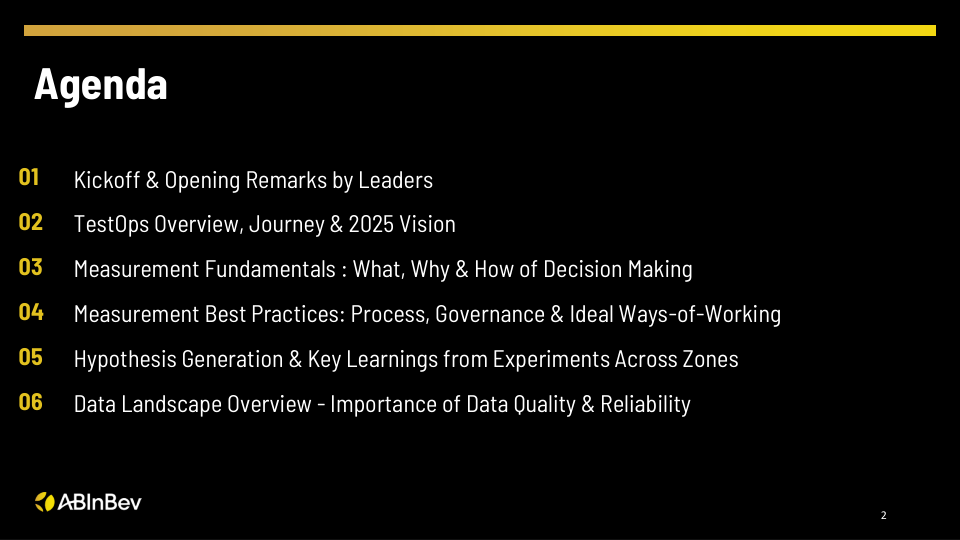

In [46]:
import fitz  # PyMuPDF
import io
from PIL import Image
import IPython.display as display

def show_pdf_page(pdf_path, page_number):
    # Open the PDF
    doc = fitz.open(pdf_path)
    
    # Ensure the page number is valid
    if page_number < 1 or page_number > len(doc):
        print("Invalid page number!")
        return

    # Get the page
    print(file)
    page = doc.load_page(page_number - 1)  # PyMuPDF uses zero-based indexing
    
    # Render page as an image
    pix = page.get_pixmap()
    img = Image.open(io.BytesIO(pix.tobytes("png")))

    # Display the image
    display.display(img)

# Example usage
show_pdf_page(r"D:\pptx project\pptbase\Day-1.pdf", 2)  # Show page 2


In [43]:
def search_with_rag_pipeline(file, query):
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient and accurate

    # Generate embeddings
    keys = list(data.keys())
    texts = list(data.values())
    embeddings = model.encode(texts, convert_to_tensor=True).detach().cpu().numpy()

    # Create FAISS index
    d = embeddings.shape[1]  # Vector dimension
    index = faiss.IndexFlatL2(d)
    index.add(embeddings)

    
    query_embedding = model.encode([query]).astype('float32')

    # Search for closest match
    _, closest_index = index.search(query_embedding, 3)

    # Display results
    print("Top Matches:")
    for idx in closest_index[0]:
        show_pdf_page(file, int(keys[idx]))


In [39]:
def get_pptx_code_from_prompt(prompt):

    system_message = f"""
You are an assistant that only returns Python code that uses the python-pptx library to generate a PowerPoint presentation. 
The code should:
1. Use the given number of slides and topic.
2. Automatically expand on the topic based on the slide count.
3. Save the final presentation to a file called 'generated_presentation.pptx'.
Do not include explanations. Return only executable Python code.
exclede ```python and ``` from your return:
{data}
"""
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content


In [29]:
def classify_intent(prompt):
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "Classify this prompt as either 'ppt' or 'rag'. Only return one word: ppt or rag."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip().lower()


In [ ]:
def save_and_run_pptx_code(code: str):
    try:
        exec(code, globals())
        print("✅ Presentation successfully generated: 'generated_presentation.pptx'")
    except Exception as e:
        print(f"❌ Error: {e}")


✅ Presentation successfully generated: 'generated_presentation.pptx'
Conversion successful!
Top Matches:


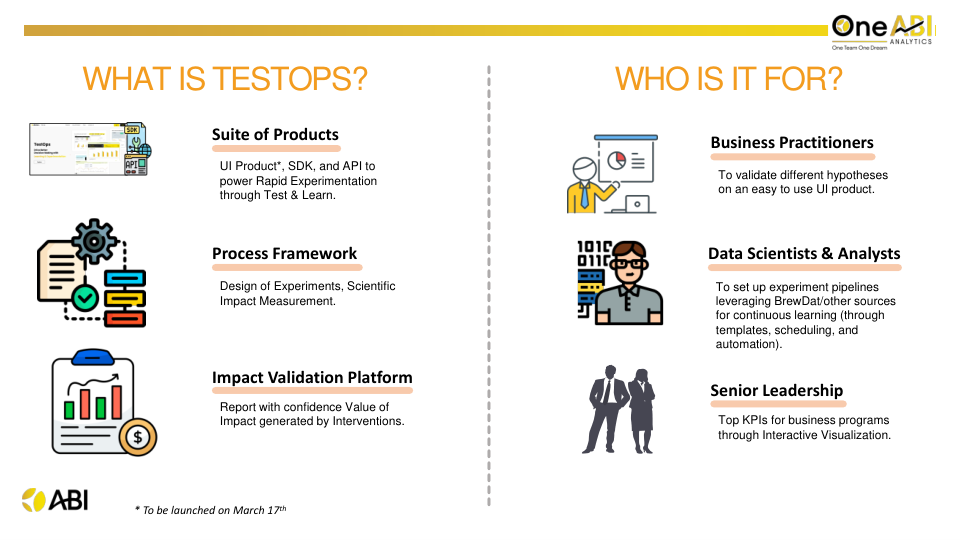

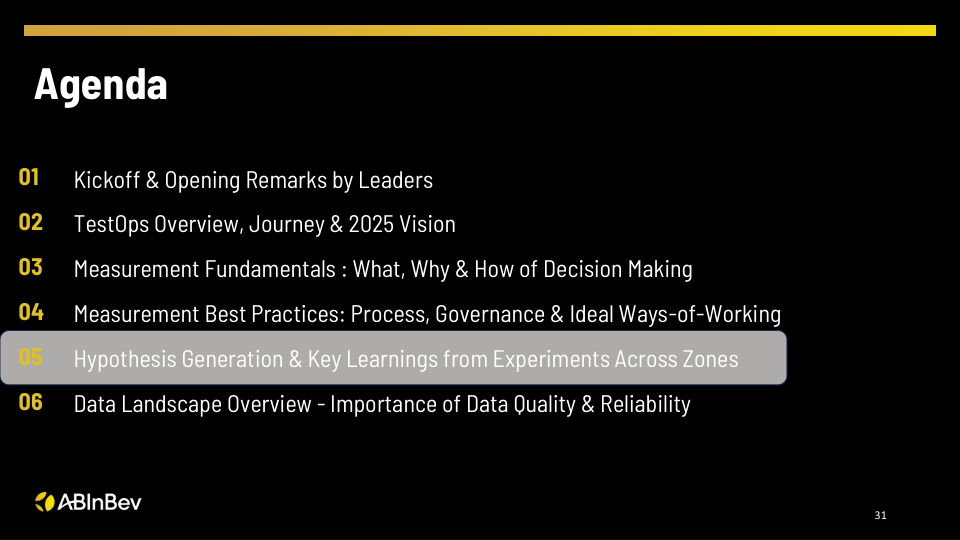

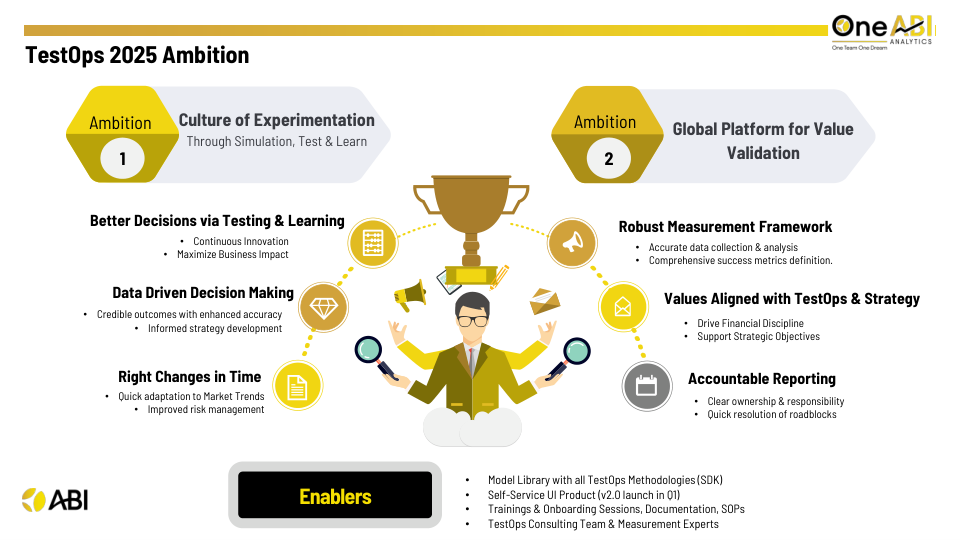

In [ ]:
user_prompt = input("Enter your request: ")
intent = classify_intent(user_prompt)


code = get_pptx_code_from_prompt(user_prompt)
save_and_run_pptx_code(code)
convert_pptx_to_pdf(r"D:\pptx project\generated_presentation.pptx", r"D:\pptx project\generated_presentation.pdf")

search_with_rag_pipeline(r"D:\pptx project\pptbase\Day-1.pdf", user_prompt)



